In [24]:
import requests
import os

owner = "InFinity54"
repo = "LoL_DDragon"
folder_path = "latest/data/en_US"
branch = "master"

destination = os.path.join("//Users//fiorillohugo//Downloads", folder_path)

api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{folder_path}?ref={branch}"
response = requests.get(api_url)

if response.status_code == 200:
    files = response.json()
    os.makedirs(destination, exist_ok=True)
    for file in files:
        if file["type"] == "file":
            file_url = file["download_url"]
            file_name = file["name"]
            file_response = requests.get(file_url)
            with open(os.path.join(destination, file_name), "wb") as f:
                f.write(file_response.content)
else:
    print("Error:", response.status_code, response.text)


In [33]:
import json
import matplotlib.pyplot as plt

In [34]:

path = "/Users/fiorillohugo/Downloads/latest/data/en_US/item.json"
with open(path, "r", encoding="utf-8") as file:
    data = json.load(file)

data = data.get("data", {})
#print(json.dumps(data, indent=4))

In [35]:
def plot_champion_stats(stats, log=False):
    
    
    levels = range(1, 19)
    
    hp_values = [stats["hp"] + stats["hpperlevel"] * (lvl - 1) for lvl in levels]
    mp_values = [stats["mp"] + stats["mpperlevel"] * (lvl - 1) for lvl in levels]
    armor_values = [stats["armor"] + stats["armorperlevel"] * (lvl - 1) for lvl in levels]
    spell_block_values = [stats["spellblock"] + stats["spellblockperlevel"] * (lvl - 1) for lvl in levels]
    attack_damage_values = [stats["attackdamage"] + stats["attackdamageperlevel"] * (lvl - 1) for lvl in levels]
    
    base_as = stats["attackspeed"]
    as_scaling = stats["attackspeedperlevel"] / 100
    attack_speed_values = [base_as * (1 + as_scaling * (lvl - 1)) for lvl in levels]
    
    plt.figure(figsize=(10, 6))
    
    if(log):
        plt.yscale('symlog') #'linear', 'log', 'symlog', 'asinh', 'logit', 'function', 'functionlog'
    
    plt.xticks(levels)

    plt.plot(levels, hp_values, label="HP")
    plt.plot(levels, mp_values, label="MP")
    plt.plot(levels, armor_values, label="Armor")
    plt.plot(levels, spell_block_values, label="Spell Block")
    plt.plot(levels, attack_damage_values, label="Attack Damage")
    plt.plot(levels, attack_speed_values, label="Attack Speed")

    

    plt.xlabel("Level")
    plt.ylabel("Value")
    plt.title("Champion Stats Evolution")
    plt.legend()
    plt.show()


In [36]:
def research(type=1, object_name="Lux", info="all", verbose_champ=False, verbose_info=False):
    
    if(type==1):
        path = "/Users/fiorillohugo/Downloads/latest/data/en_US/championFull.json"
    else:
        path = "/Users/fiorillohugo/Downloads/latest/data/en_US/item.json"
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)

    data = data.get("data", {})
    if(info == "all"):
        return data
    
    
    object_info = data.get(object_name)
    if(verbose_champ):
        print(json.dumps(object_info, indent=4))

    if(info == "none"):
        return object_info
    
    
    object_detail_info = object_info.get(info)
    if(verbose_info):
        print(json.dumps(object_detail_info, indent=4))

    return object_detail_info



{
    "hp": 656,
    "hpperlevel": 115,
    "mp": 350,
    "mpperlevel": 50,
    "movespeed": 350,
    "armor": 35,
    "armorperlevel": 5,
    "spellblock": 32,
    "spellblockperlevel": 2.05,
    "attackrange": 125,
    "hpregen": 9.5,
    "hpregenperlevel": 0.8,
    "mpregen": 7.5,
    "mpregenperlevel": 0.75,
    "crit": 0,
    "critperlevel": 0,
    "attackdamage": 65,
    "attackdamageperlevel": 5,
    "attackspeedperlevel": 2.5,
    "attackspeed": 0.625
}


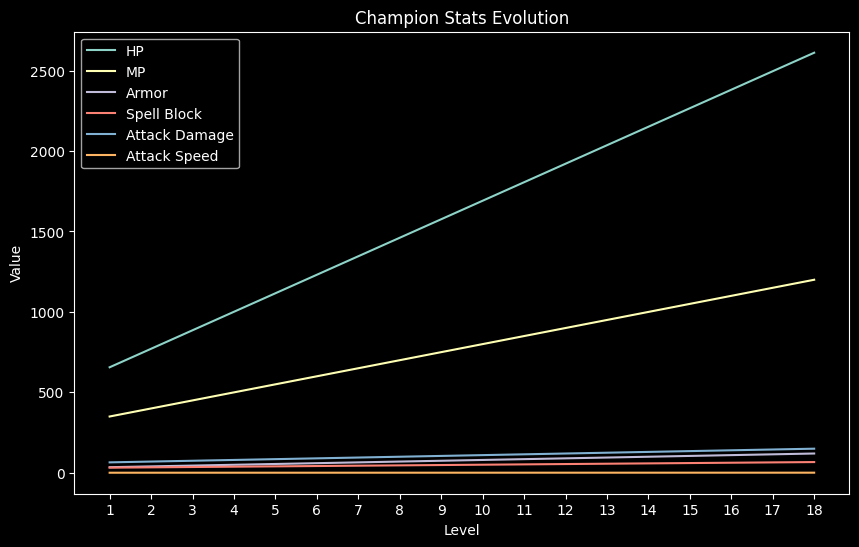

In [37]:
A = research(1, "Illaoi", "stats", False, True)        #research(2, "3053", "stats", True, True)
plot_champion_stats(A, False)

In [38]:
import re

def parse_item_for_quant_analysis(item_data):
    description = item_data.get("description", "")

    # Extract numeric stats within <stats>...</stats>
    stats_pattern = r"<stats>(.*?)</stats>"
    stats_match = re.search(stats_pattern, description, flags=re.DOTALL)
    stats_dict = {}
    if stats_match:
        stats_block = stats_match.group(1)
        for line in stats_block.split("<br>"):
            line_clean = re.sub(r"<.*?>", "", line).strip()
            match = re.match(r"^(\d+(?:\.\d+)?%?)\s+(.*)$", line_clean)
            if match:
                val, key = match.groups()
                stats_dict[key.lower()] = val

    # Remove <stats> block and remaining tags for further analysis
    desc_no_stats = re.sub(stats_pattern, "", description, flags=re.DOTALL)
    desc_no_stats = re.sub(r"<.*?>", "", desc_no_stats)

    pattern = r"(\d+(?:\.\d+)?%?)\s+([A-Za-z%]+)"
    matches = re.findall(pattern, desc_no_stats)
    extra_data = {}
    for value, label in matches:
        label = label.lower()
        if label not in extra_data:
            extra_data[label] = []
        extra_data[label].append(value)

    return {
        "stats_block": stats_dict,
        "parsed_description": extra_data
    }

if __name__ == "__main__":
    item_data_example = {
        "name": "Sterak's Gage",
        "description": (
            "<mainText><stats><attention>400</attention> Health<br>"
            "<attention>20%</attention> Tenacity</stats><br><br>"
            "<passive>The Claws that Catch</passive><br>"
            "Gain <scaleAD>bonus Attack Damage</scaleAD>.<br><br>"
            "<passive>Lifeline</passive><br>"
            "Taking damage that would reduce your Health below 30% grants a "
            "<shield>decaying Shield</shield> for 4.5 seconds.</mainText>"
        )
    }
    
    result = parse_item_for_quant_analysis(item_data_example)
    print(result)


{'stats_block': {'health': '400', 'tenacity': '20%'}, 'parsed_description': {'grants': ['30%'], 'seconds': ['4.5']}}


In [39]:
import json

def load_data(type):
    if type == 1:
        path = "/Users/fiorillohugo/Downloads/latest/data/en_US/championFull.json"
    else:
        path = "/Users/fiorillohugo/Downloads/latest/data/en_US/item.json"
    
    with open(path, 'r') as file:
        data = json.load(file)
    return data

champion_data = load_data(1)
item_data = load_data(2)

In [40]:
class Champion:
    def __init__(self, champion_json):
        self.name = champion_json['name']
        self.stats = champion_json['stats']
        self.spells = champion_json['spells']
        self.passive = champion_json['passive']
    
    def get_stat(self, stat_name):
        return self.stats.get(stat_name, 0)

class Item:
    def __init__(self, item_json):
        self.name = item_json['name']
        self.stats = item_json['stats']
    
    def get_stat(self, stat_name):
        return self.stats.get(stat_name, 0)

In [41]:
def filter_items(items_data):
    legendary_items = []
    boots = []
    
    for item in items_data.values():
        if item.get('depth', 0) >= 2:
            legendary_items.append(Item(item))
        elif 'Boots' in item.get('name', ''):
            boots.append(Item(item))
    
    return legendary_items, boots

In [42]:
def calculate_damage(champion, item, opponent):
    base_damage = champion.get_stat('attackdamage') + item.get_stat('FlatPhysicalDamageMod')
    return base_damage

def calculate_ttk(champion, items, opponent):
    total_damage = sum(calculate_damage(champion, item, opponent) for item in items)
    opponent_hp = opponent.get_stat('hp')
    return opponent_hp / total_damage

def calculate_ttl(champion, items, opponent):
    total_damage = sum(calculate_damage(opponent, item, champion) for item in items)
    champion_hp = champion.get_stat('hp')
    return champion_hp / total_damage

In [43]:
from itertools import combinations

def optimize_build(champion, opponent, legendary_items, boots):
    best_build = []
    best_ttk = float('inf')
    
    # Try all combinations of 5 legendary items and 1 pair of boots
    for legendary_combo in combinations(legendary_items, 5):
        for boot in boots:
            items = list(legendary_combo) + [boot]
            ttk = calculate_ttk(champion, items, opponent)
            ttl = calculate_ttl(champion, items, opponent)
            
            if ttk < best_ttk and ttl > ttk:
                best_ttk = ttk
                best_build = items
    
    return best_build

In [ ]:
def main():
    champion_json = champion_data['data']['Volibear']
    opponent_json = champion_data['data']['Garen']  # Example opponent
    items_data = item_data['data']
    
    # Filter items
    legendary_items, boots = filter_items(items_data)
    
    champion = Champion(champion_json)
    opponent = Champion(opponent_json)

    best_build = optimize_build(champion, opponent, legendary_items, boots)
    
    print("Best Build:", [item.name for item in best_build])

if __name__ == "__main__":
    main()

KeyboardInterrupt: 